In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
import time
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout, Input, AveragePooling1D, LSTM
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

from sklearn.decomposition import TruncatedSVD

In [14]:
# 1. data processing
# a. retain the "text" & "stars" columns, split the strings using delimiters, and create DataFrames for training & test set
file_path = 'yelp.csv'
df = pd.read_csv(file_path)
df_filtered = df[['text', 'stars']]
print("original: \n", df_filtered)

# a. convert score>=4 to Score=1, and convert others to Score=0 (1: positive 0: negative) 
df_filtered = df_filtered.copy()
df_filtered.loc[df_filtered.index, 'stars'] = df_filtered['stars'].apply(lambda x: 1 if x >= 4 else 0)
print("convert to 1: \n", df_filtered)

# Remove punctuation and extra spaces from the 'text' column
df_filtered.loc[df_filtered.index, 'text'] = df_filtered['text'].str.replace(f'[{string.punctuation}]', '', regex=True)
df_filtered.loc[df_filtered.index, 'text'] = df_filtered['text'].str.replace(r'\s+', ' ', regex=True).str.strip()

# Split the text in the 'text' column using the delimiter
df_filtered.loc[df_filtered.index, 'text'] = df_filtered['text'].str.split(' ')
print("split string: \n", df_filtered)

# create DataFrames for training & test set
df_dataframe = pd.DataFrame(df_filtered)
train_df, test_df = train_test_split(df_dataframe, test_size=0.2, random_state=42)
print("i am tain_df: \n", train_df)
print("i am test_df: \n", test_df)

original: 
                                                    text  stars
0     My wife took me here on my birthday for breakf...      5
1     I have no idea why some people give bad review...      5
2     love the gyro plate. Rice is so good and I als...      4
3     Rosie, Dakota, and I LOVE Chaparral Dog Park!!...      5
4     General Manager Scott Petello is a good egg!!!...      5
...                                                 ...    ...
9995  First visit...Had lunch here today - used my G...      3
9996  Should be called house of deliciousness!\n\nI ...      4
9997  I recently visited Olive and Ivy for business ...      4
9998  My nephew just moved to Scottsdale recently so...      2
9999  4-5 locations.. all 4.5 star average.. I think...      5

[10000 rows x 2 columns]
convert to 1: 
                                                    text  stars
0     My wife took me here on my birthday for breakf...      1
1     I have no idea why some people give bad review...      1
2

In [15]:
# b. Remove stop words
vectorizer = CountVectorizer(stop_words='english')
df_filtered.loc[df_filtered.index, 'text'] = df_filtered['text'].apply(lambda x: ' '.join(vectorizer.build_analyzer()(' '.join(x))))
print(df_filtered)

                                                   text  stars
0     wife took birthday breakfast excellent weather...      1
1     idea people bad reviews place goes probably gr...      1
2         love gyro plate rice good dig candy selection      1
3     rosie dakota love chaparral dog park convenien...      1
4     general manager scott petello good egg let ass...      1
...                                                 ...    ...
9995  visithad lunch today used groupon ordered brus...      0
9996  called house deliciousness item item blah blah...      1
9997  recently visited olive ivy business week visit...      1
9998  nephew just moved scottsdale recently bunch fr...      0
9999  45 locations 45 star average think arizona rea...      1

[10000 rows x 2 columns]


In [16]:
# c. Convert text to vectors (TF-IDF & Ｗord2vec)
# Implement TF-IDF
start_time = time.time()
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df_filtered['text'])

end_time = time.time()
print(f"TF-IDF time: {end_time - start_time} sec")
print("TF-IDF Matrix:\n", tfidf_matrix.toarray())

# Implement Word2Vec
start_time = time.time()
word2vec_model = Word2Vec(df_filtered['text'], vector_size=100, window=5, min_count=1, workers=4)
def average_word_vectors(words, model, vector_size):
    vector = np.zeros(vector_size)
    count = 0
    for word in words:
        if word in model.wv:
            vector += model.wv[word]
            count += 1
    if count != 0:
        vector /= count
    return vector
df_filtered['Word2Vec_Vector'] = df_filtered['text'].apply(lambda x: average_word_vectors(x, word2vec_model, 100))
Word2Vec_vectors = np.array(df_filtered['Word2Vec_Vector'].tolist())
end_time = time.time()
print(f"Word2Vec time: {end_time - start_time} sec")
print("Word2Vec Matrix:\n", Word2Vec_vectors)

TF-IDF time: 0.34210896492004395 sec
TF-IDF Matrix:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Word2Vec time: 9.475417852401733 sec
Word2Vec Matrix:
 [[ 0.015528   -0.00754134  0.11188385 ...  0.03197719  0.03994665
   0.08119551]
 [-0.00254148 -0.03012547  0.09617856 ...  0.03544404  0.06222651
   0.10526747]
 [-0.02395847 -0.01797984  0.06700248 ... -0.02983589  0.03529759
   0.13861369]
 ...
 [-0.00245694 -0.02038218  0.09760791 ...  0.01834561  0.04242427
   0.08347814]
 [-0.02045323  0.00973607  0.10575235 ...  0.03089304  0.02729888
   0.11512083]
 [-0.03094456 -0.01168373  0.08386361 ...  0.03071236  0.03039351
   0.09193904]]


In [21]:
# 2. Modeling
# a. Use CNN and LSTM to build models separately on the training data
# b. Add a Dropout Layer, set the Dropout parameter, and perform a comparison

# CNN
# TF-IDF
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf, idx_train_tfidf, idx_test_tfidf = \
    train_test_split(tfidf_matrix, df_filtered['stars'], df_filtered.index, test_size=0.2, random_state=42)

# adjust the shapes of X_train and X_test
X_train_dense_tfidf = X_train_tfidf.toarray()
X_test_dense_tfidf = X_test_tfidf.toarray()
X_train_cnn_tfidf = X_train_dense_tfidf.reshape((X_train_dense_tfidf.shape[0], X_train_dense_tfidf.shape[1], 1))
X_test_cnn_tfidf = X_test_dense_tfidf.reshape((X_test_dense_tfidf.shape[0], X_test_dense_tfidf.shape[1], 1))

# define the CNN model
cnn_model_tfidf = Sequential([
    Input(shape=(X_train_cnn_tfidf.shape[1], X_train_cnn_tfidf.shape[2])),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    AveragePooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])
# drop
cnn_model_tfidf_drop = Sequential([
    Input(shape=(X_train_cnn_tfidf.shape[1], X_train_cnn_tfidf.shape[2])),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    AveragePooling1D(pool_size=2),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# compiling & training
print("CNN Model TF-IDF training phase: \n")
cnn_model_tfidf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_tfidf = cnn_model_tfidf.fit(X_train_cnn_tfidf, y_train_tfidf, epochs=2, batch_size=64, validation_split=0.2)
# drop
print("\nCNN Model TF-IDF with drop training phase: \n")
cnn_model_tfidf_drop.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_tfidf_drop = cnn_model_tfidf_drop.fit(X_train_cnn_tfidf, y_train_tfidf, epochs=2, batch_size=64, validation_split=0.2)

# 3. evaluate the model
# a. test the model built in step 2 using the test data, and calculate the accuracy
accuracy_tfidf = cnn_model_tfidf.evaluate(X_test_cnn_tfidf, y_test_tfidf, verbose=0)[1]
print(f"Tfidf Accuracy: {accuracy_tfidf:.4f}")
# drop
accuracy_tfidf_drop = cnn_model_tfidf_drop.evaluate(X_test_cnn_tfidf, y_test_tfidf, verbose=0)[1]
print(f"Tfidf-Drop Accuracy: {accuracy_tfidf_drop:.4f}")

CNN Model TF-IDF training phase: 

Epoch 1/2
100/100 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - accuracy: 0.7025 - loss: 0.6315 - val_accuracy: 0.8263 - val_loss: 0.3971
Epoch 2/2
100/100 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - accuracy: 0.9170 - loss: 0.2430 - val_accuracy: 0.8163 - val_loss: 0.4186

CNN Model TF-IDF with drop training phase: 

Epoch 1/2
100/100 ━━━━━━━━━━━━━━━━━━━━ 245s 2s/step - accuracy: 0.6498 - loss: 0.6760 - val_accuracy: 0.8219 - val_loss: 0.4269
Epoch 2/2
100/100 ━━━━━━━━━━━━━━━━━━━━ 245s 2s/step - accuracy: 0.8880 - loss: 0.3057 - val_accuracy: 0.8213 - val_loss: 0.3916
Tfidf Accuracy: 0.8220
Tfidf-Drop Accuracy: 0.8300


In [22]:
# CNN
# Word2vec
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec, idx_train_word2vec, idx_test_word2vec = \
    train_test_split(Word2Vec_vectors, df_filtered['stars'], df_filtered.index, test_size=0.2, random_state=42)

# adjust the shapes of X_train and X_test
X_train_cnn_word2vec = X_train_word2vec.reshape((X_train_word2vec.shape[0], X_train_word2vec.shape[1], 1))
X_test_cnn_word2vec = X_test_word2vec.reshape((X_test_word2vec.shape[0], X_test_word2vec.shape[1], 1))

# define the CNN model
cnn_model_word2vec = Sequential([
    Input(shape=(X_train_cnn_word2vec.shape[1], X_train_cnn_word2vec.shape[2])),
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    AveragePooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])
# drop
cnn_model_word2vec_drop = Sequential([
    Input(shape=(X_train_cnn_word2vec.shape[1], X_train_cnn_word2vec.shape[2])),
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    AveragePooling1D(pool_size=2),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# compiling & training
print("CNN Model Word2vec training phase: \n")
cnn_model_word2vec.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_word2vec = cnn_model_word2vec.fit(X_train_cnn_word2vec, y_train_word2vec, epochs=10, batch_size=64, validation_split=0.2)
# drop
print("\nCNN Model Word2vec with drop training phase: \n")
cnn_model_word2vec_drop.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_word2vec_drop = cnn_model_word2vec_drop.fit(X_train_cnn_word2vec, y_train_word2vec, epochs=10, batch_size=64, validation_split=0.2)

# 3. evaluate the model
# a. test the model built in step 2 using the test data, and calculate the accuracy
accuracy_word2vec = cnn_model_word2vec.evaluate(X_test_cnn_word2vec, y_test_word2vec, verbose=0)[1]
print(f"Word2vec Accuracy: {accuracy_word2vec:.4f}")
# drop
accuracy_word2vec_drop = cnn_model_word2vec_drop.evaluate(X_test_cnn_word2vec, y_test_word2vec, verbose=0)[1]
print(f"Word2vec-Drop Accuracy: {accuracy_word2vec_drop:.4f}")

CNN Model Word2vec training phase: 

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6844 - loss: 0.6392 - val_accuracy: 0.6931 - val_loss: 0.6167
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6761 - loss: 0.6275 - val_accuracy: 0.6931 - val_loss: 0.6058
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6809 - loss: 0.6129 - val_accuracy: 0.6931 - val_loss: 0.5988
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6824 - loss: 0.6109 - val_accuracy: 0.6931 - val_loss: 0.5954
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6834 - loss: 0.6024 - val_accuracy: 0.6900 - val_loss: 0.6177
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6939 - loss: 0.6013 - val_accuracy: 0.6925 - val_loss: 0.5929
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6687 - loss: 0.6123 - val_accuracy: 0.6906 - val_loss: 0.6050
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accur

In [27]:
# LSTM
# Word2vec
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec, idx_train_word2vec, idx_test_word2vec = \
    train_test_split(Word2Vec_vectors, df_filtered['stars'], df_filtered.index, test_size=0.2, random_state=42)

# adjust the shapes of X_train and X_test
X_train_lstm = X_train_word2vec.reshape((X_train_word2vec.shape[0], X_train_word2vec.shape[1], 1))
X_test_lstm = X_test_word2vec.reshape((X_test_word2vec.shape[0], X_test_word2vec.shape[1], 1))

# define the LSTM model
lstm_model = Sequential([
    Input(shape=(X_train_lstm.shape[1], 1)),
    LSTM(128, return_sequences=True),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])
# drop
lstm_model_drop = Sequential([
    Input(shape=(X_train_lstm.shape[1], 1)),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# compiling
optimizer = Adam(learning_rate=0.0005)
lstm_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
# drop
optimizer_drop = Adam(learning_rate=0.0005)
lstm_model_drop.compile(optimizer=optimizer_drop, loss='binary_crossentropy', metrics=['accuracy'])


# training
print("LSTM Model Word2vec training phase: \n")
history_word2vec_lstm = lstm_model.fit(X_train_lstm, y_train_word2vec, epochs=10, batch_size=32, validation_split=0.2)
# drop
print("\nLSTM Model Word2vec with drop training phase: \n")
history_word2vec_lstm_drop = lstm_model_drop.fit(X_train_lstm, y_train_word2vec, epochs=10, batch_size=32, validation_split=0.2)

# 3. evaluate the model
# a. test the model built in step 2 using the test data, and calculate the accuracy
lstm_accuracy = lstm_model.evaluate(X_test_lstm, y_test_word2vec, verbose=0)[1]
print(f"LSTM Accuracy: {lstm_accuracy:.4f}")
# drop
lstm_accuracy_drop = lstm_model_drop.evaluate(X_test_lstm, y_test_word2vec, verbose=0)[1]
print(f"LSTM-Drop Accuracy: {lstm_accuracy_drop:.4f}")

LSTM Model Word2vec training phase: 

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 22s 98ms/step - accuracy: 0.6692 - loss: 0.6425 - val_accuracy: 0.6931 - val_loss: 0.6217
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 19s 96ms/step - accuracy: 0.6761 - loss: 0.6310 - val_accuracy: 0.6931 - val_loss: 0.6198
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 19s 95ms/step - accuracy: 0.6858 - loss: 0.6247 - val_accuracy: 0.6931 - val_loss: 0.6166
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 19s 97ms/step - accuracy: 0.6782 - loss: 0.6297 - val_accuracy: 0.6931 - val_loss: 0.6166
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 19s 97ms/step - accuracy: 0.6808 - loss: 0.6270 - val_accuracy: 0.6931 - val_loss: 0.6174
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 19s 97ms/step - accuracy: 0.6812 - loss: 0.6266 - val_accuracy: 0.6931 - val_loss: 0.6166
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 19s 97ms/step - accuracy: 0.6835 - loss: 0.6247 - val_accuracy: 0.6931 - val_loss: 0.6175
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 19s 97ms/ste

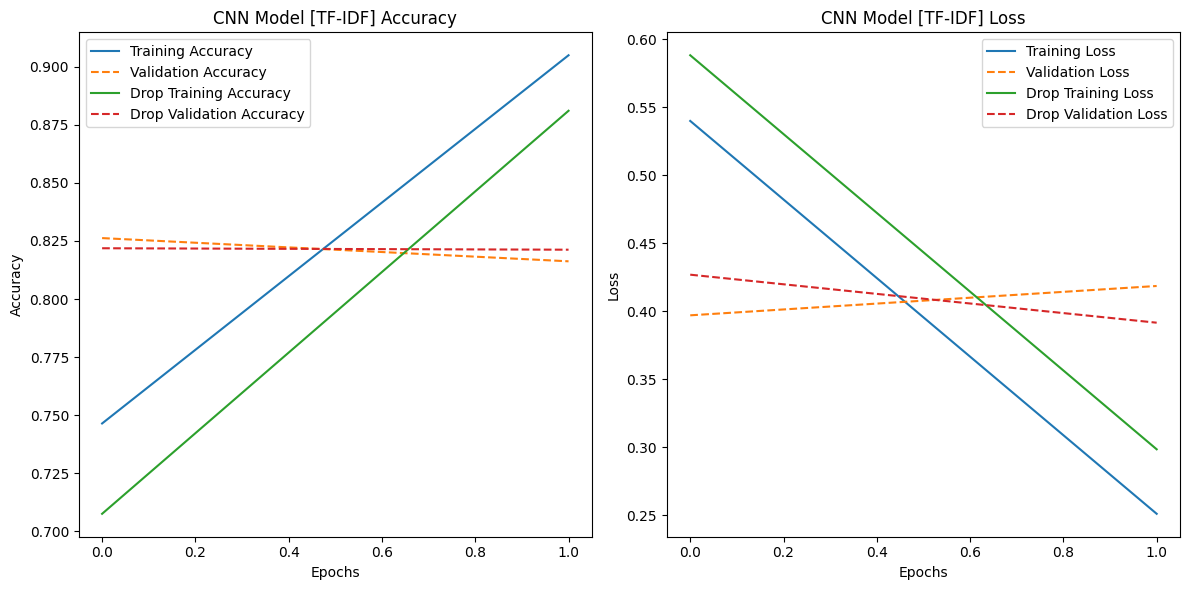

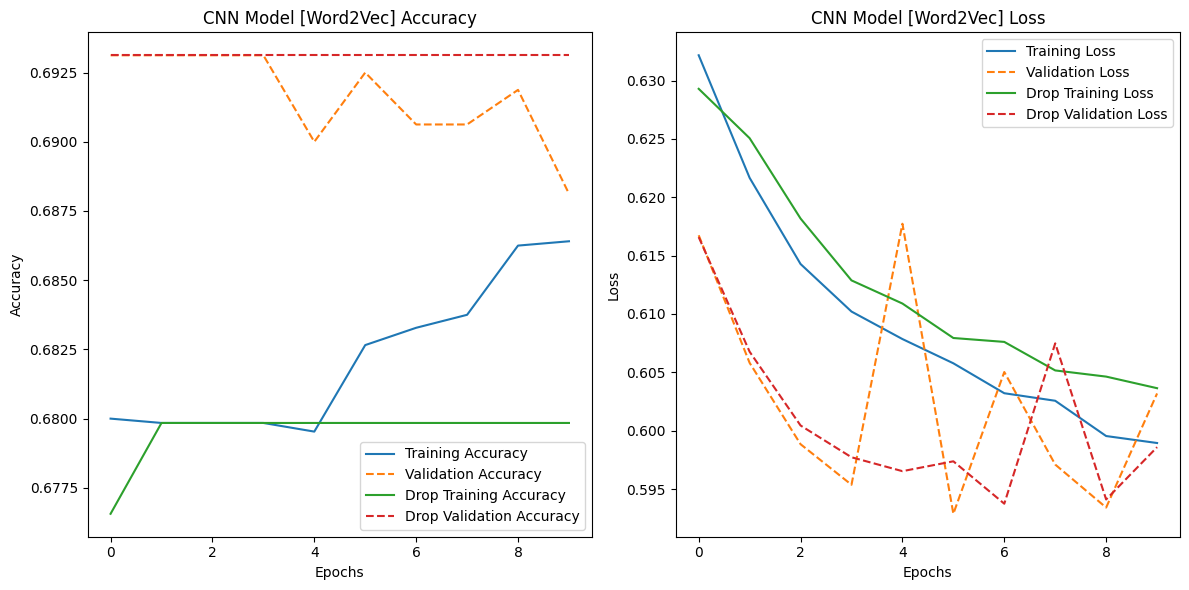

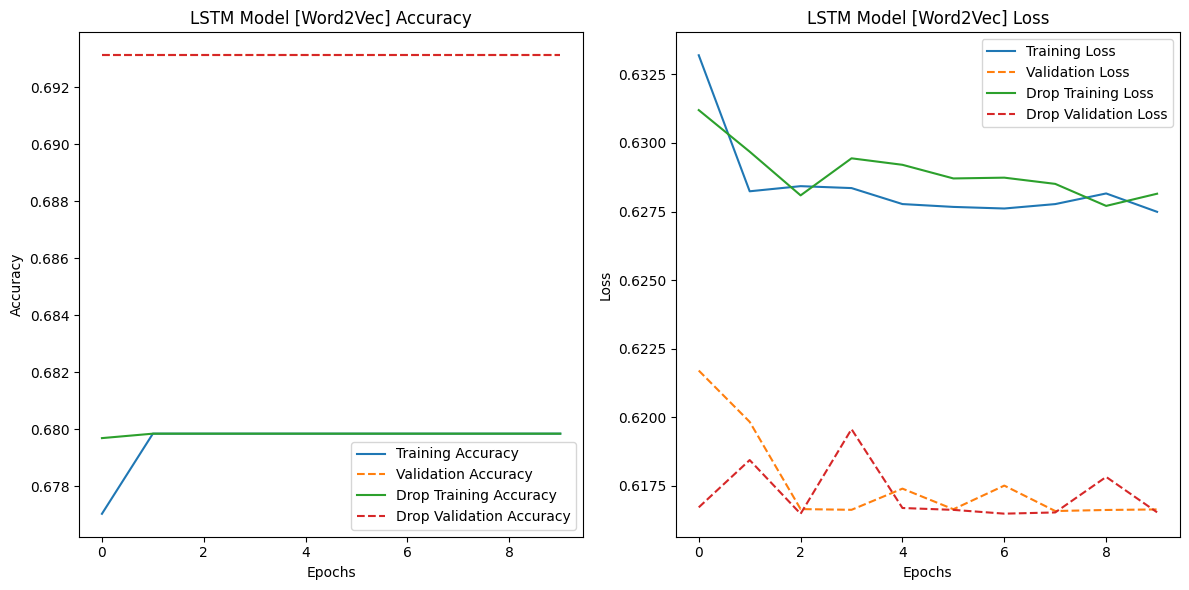

In [28]:
# c. plot the changes in Accuracy and Loss during the training process
def plot_model_history(history, history_drop, model_name):
    plt.figure(figsize=(12, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
    plt.plot(history_drop.history['accuracy'], label='Drop Training Accuracy')
    plt.plot(history_drop.history['val_accuracy'], label='Drop Validation Accuracy', linestyle='--')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
    plt.plot(history_drop.history['loss'], label='Drop Training Loss')
    plt.plot(history_drop.history['val_loss'], label='Drop Validation Loss', linestyle='--')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# CNN-TF-IDF
plot_model_history(history_tfidf, history_tfidf_drop, "CNN Model [TF-IDF]")

# CNN-Word2Vec
plot_model_history(history_word2vec, history_word2vec_drop, "CNN Model [Word2Vec]")

# LSTM-Word2Vec
plot_model_history(history_word2vec_lstm, history_word2vec_lstm_drop, "LSTM Model [Word2Vec]")